# Boston Housing Case Study II
### Exploring Regularization and the Bias–Variance Trade-off 

In this notebook, we build upon **Notebook 1 (Parametric vs Non-Parametric Regression)** 

by focusing on how **model complexity** affects performance, and how **regularization techniques** 

can help us achieve better generalization.

We use the same **Boston Housing dataset** to explore three key regression 

approaches that progressively address **overfitting** and **underfitting**:

1. **Polynomial Regression** — introduces non-linearity by adding higher-order terms of the predictors.  
2. **Ridge Regression** — a regularized linear model that penalizes large coefficients (L2 penalty).  
3. **Lasso Regression** — similar to Ridge but with an L1 penalty that can shrink some coefficients to exactly zero, enabling **feature selection**.

### Key Concepts

- **Bias–Variance Trade-off**  
  - **High bias** → model is too simple (underfits the data).  
  - **High variance** → model is too complex (overfits the data).  
  - The goal is to find the balance point that minimizes **Test MSE**.

- **Polynomial Features**  
  Adding powers of predictors increases flexibility but also the risk of overfitting.  
  We will examine how the degree of the polynomial influences model error.

- **Regularization Techniques**  
  - **Ridge (L2):** penalizes large coefficients, improving stability.  
  - **Lasso (L1):** performs variable selection by shrinking some coefficients to zero.  
  Both methods aim to **reduce variance** without excessively increasing bias.





# 1. DATA LOADING


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml

import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


boston = fetch_openml(name="boston", version=1, as_frame=True)
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = pd.to_numeric(boston.target, errors='coerce')

X = df.drop('MEDV', axis=1)
y = df['MEDV']

print("Data shape:", df.shape)
print("Features:", list(X.columns))
print("Target: MEDV")

Data shape: (506, 14)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target: MEDV


In [3]:
# TRAIN/TEST SPLIT & STANDARDIZATION (ORIGINAL FEATURES)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples:  {X_train.shape[0]}")
print(f"Test samples:      {X_test.shape[0]}")
print(f"Original features: {X_train.shape[1]}")

results = {}

Training samples:  404
Test samples:      102
Original features: 13


## 2. Bias–Variance Trade-off via Polynomial Degree (Unregularized)

In this section, we fit **Polynomial Regression** models of increasing degree — *without applying any regularization*.  

This experiment helps understand how higher-degree polynomials can reduce bias but increase variance, leading to potential overfitting.

### Steps

1. **Generate Polynomial Features**  
   - Use `PolynomialFeatures(degree=d)` to expand the input data with higher-order and interaction terms (e.g., quadratic or cubic combinations).  
   - These features allow a linear model to capture **non-linear relationships** between predictors and the target.

2. **Train Unregularized Linear Regression**  
   - Fit a standard `LinearRegression()` model on the transformed features for each polynomial degree.

3. **Evaluate Model Performance**  
   - Compute and store:
     - **Training MSE** and **Test MSE**
     - **Number of generated features** 

In [4]:
#TODO 1: Polynomial Regression — Exploring Model Complexity
# Your task:
# 1. Create polynomial features for degrees 1–4 using PolynomialFeatures.
# 2. Fit a LinearRegression model for each degree and record:
#    - Training MSE
#    - Test MSE
# 3. Identify which degree yields the lowest Test MSE (best generalization).
#


degrees = [1, 2, 3, 4]
train_mse_deg = []
test_mse_deg = []

X_train_poly = None
X_test_poly = None

for d in degrees:
    # ============================================================
    # TODO: YOUR CODE HERE
    # ============================================================
    # Step 1: Create polynomial features of degree d
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly_d = poly.fit_transform(X_train_scaled)
    X_test_poly_d = poly.transform(X_test_scaled)
    
    # Step 2: Fit a Linear Regression model
    lr_d = LinearRegression()
    lr_d.fit(X_train_poly_d, y_train)
    
    # Step 3: Make predictions on training and test sets
    y_train_pred_d = lr_d.predict(X_train_poly_d)
    y_test_pred_d = lr_d.predict(X_test_poly_d)
    
    # Step 4: Calculate MSE for both sets
    mse_train = mean_squared_error(y_train, y_train_pred_d)
    mse_test = mean_squared_error(y_test, y_test_pred_d)
    
    # Step 5: Append MSE values to the lists
    train_mse_deg.append(mse_train)
    test_mse_deg.append(mse_test)
    
    # Step 6: Print results
    print(f"Degree {d}: Train MSE = {mse_train:.4f}, Test MSE = {mse_test:.4f}, "
           f"Features = {X_train_poly_d.shape[1]}")
    
    # Step 7: Store degree=2 design matrix for later use
    if d == 2:
        X_train_poly = X_train_poly_d
        X_test_poly = X_test_poly_d
        n_features_poly = X_train_poly_d.shape[1]
    # ============================================================
    # END TODO
    # ============================================================
    pass  

# POLYNOMIAL BASELINE (UNREGULARIZED)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_train_pred_poly = lr_poly.predict(X_train_poly)
y_test_pred_poly = lr_poly.predict(X_test_poly)

train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

print('\n')
print(f"Training MSE (poly d=2): {train_mse_poly:.4f}")
print(f"Test MSE (poly d=2):     {test_mse_poly:.4f}")
print(f"Training R² (poly d=2):  {train_r2_poly:.4f}")
print(f"Test R² (poly d=2):      {test_r2_poly:.4f}")
print(f"Gap (Test - Train MSE):  {test_mse_poly - train_mse_poly:.4f}")
print(f"Polynomial features (d=2): {n_features_poly}")

results['Linear (Polynomial)'] = {
    'features': n_features_poly,
    'train_mse': train_mse_poly,
    'test_mse': test_mse_poly,
    'train_r2': train_r2_poly,
    'test_r2': test_r2_poly,
}

Degree 1: Train MSE = 21.6414, Test MSE = 24.2911, Features = 13
Degree 2: Train MSE = 5.1315, Test MSE = 14.2573, Features = 104
Degree 3: Train MSE = 0.0000, Test MSE = 7734.5772, Features = 559
Degree 4: Train MSE = 0.0000, Test MSE = 253.1183, Features = 2379


Training MSE (poly d=2): 5.1315
Test MSE (poly d=2):     14.2573
Training R² (poly d=2):  0.9409
Test R² (poly d=2):      0.8056
Gap (Test - Train MSE):  9.1259
Polynomial features (d=2): 104


## 3. Ridge Regression (L2 Regularization) on Polynomial Features (Degree = 2)

We apply **Ridge Regression**  on the previously generated **degree-2 polynomial features** 

to address the **overfitting problem** observed in unregularized polynomial models.

Ridge introduces a penalty on large coefficient values, effectively **shrinking them toward zero**

 and reducing model variance while maintaining all predictors in the model.


### Steps

1. **Define the Regularization Path**  
   We test a range of α values (regularization strengths) using:
   ```python
   alphas = np.logspace(-2, 4, 20)

In [6]:

# RIDGE REGRESSION (L2) ON POLYNOMIAL FEATURES
print("\n Ridge Regression on Polynomial Features (Degree = 2)")
print("-" * 40)

# Define a range of alpha values to test (e.g from 0.01 to 10,000)
alphas = np.logspace(-2, 4, 100)

# ============================================================
# TODO: YOUR CODE HERE - Find Optimal Alpha
# ============================================================
# Step 1: Create a RidgeCV object with the alphas and 5-fold CV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Step 2: Fit the model on training data
ridge_cv.fit(X_train_poly, y_train)

# Step 3: Extract the optimal alpha value
ridge_alpha_opt = ridge_cv.alpha_

# Step 4: Print the optimal alpha
print(f"Optimal α (Ridge): {ridge_alpha_opt:.4f}")
# ============================================================
# END TODO 
# ============================================================

y_train_pred_ridge = ridge_cv.predict(X_train_poly)
y_test_pred_ridge = ridge_cv.predict(X_test_poly)

train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"Training MSE (Ridge): {train_mse_ridge:.4f}")
print(f"Test MSE (Ridge):     {test_mse_ridge:.4f}")
print(f"Training R² (Ridge):  {train_r2_ridge:.4f}")
print(f"Test R² (Ridge):      {test_r2_ridge:.4f}")

results['Ridge'] = {
    'features': n_features_poly,
    'train_mse': train_mse_ridge,
    'test_mse': test_mse_ridge,
    'train_r2': train_r2_ridge,
    'test_r2': test_r2_ridge,
}

# Ridge: Bias–Variance vs Alpha (Error Curves)
ridge_train_mse_path = []
ridge_test_mse_path = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_poly, y_train)

    y_train_pred = ridge.predict(X_train_poly)
    y_test_pred = ridge.predict(X_test_poly)

    ridge_train_mse_path.append(mean_squared_error(y_train, y_train_pred))
    ridge_test_mse_path.append(mean_squared_error(y_test, y_test_pred))




 Ridge Regression on Polynomial Features (Degree = 2)
----------------------------------------
Optimal α (Ridge): 21.5443
Training MSE (Ridge): 6.9113
Test MSE (Ridge):     13.1838
Training R² (Ridge):  0.9204
Test R² (Ridge):      0.8202


In [ ]:
# POLYNOMIAL FEATURES (DEGREE = 2)


poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original features:    {X_train_scaled.shape[1]}")
print(f"Polynomial features:  {X_train_poly.shape[1]}")
print(f"Feature expansion:    {X_train_poly.shape[1]/X_train_scaled.shape[1]:.1f}x")
print(f"p/n ratio:            {X_train_poly.shape[1]/X_train_poly.shape[0]:.2f}")

# Linear Regression on polynomial features


lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_train_pred_poly = lr_poly.predict(X_train_poly)
y_test_pred_poly = lr_poly.predict(X_test_poly)

train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

print(f"Training MSE: {train_mse_poly:.4f}")
print(f"Test MSE:     {test_mse_poly:.4f}")
print(f"Training R²:  {train_r2_poly:.4f}")
print(f"Test R²:      {test_r2_poly:.4f}")
print(f"Gap (Test - Train MSE): {test_mse_poly - train_mse_poly:.4f}")

results['Linear (Polynomial)'] = {
    'features': X_train_poly.shape[1],
    'train_mse': train_mse_poly,
    'test_mse': test_mse_poly,
    'train_r2': train_r2_poly,
    'test_r2': test_r2_poly,
}

Original features:    13
Polynomial features:  104
Feature expansion:    8.0x
p/n ratio:            0.26
Training MSE: 5.1403
Test MSE:     14.2897
Training R²:  0.9408
Test R²:      0.8051
Gap (Test - Train MSE): 9.1495


## 4. Lasso Regression (L1 Regularization) on Polynomial Features (Degree = 2)

We apply **Lasso Regression** on the same **degree-2 polynomial features** to address overfitting 

and explore how **L1 regularization** differs from Ridge (L2).  

### Steps

1. **Cross-Validation to Select Optimal α**  
   - Use `LassoCV` with 5-fold cross-validation over a range of α values.  
   - The model automatically identifies the α that minimizes cross-validated error, balancing model complexity and generalization.

2. **Model Evaluation**  
   - Compute key metrics:
     - **Training MSE** and **Test MSE**  
     - **Training R²** and **Test R²**  
   - Compare performance against Ridge and unregularized Polynomial Regression to assess the effect of L1 regularization.



In [ ]:
# LASSO REGRESSION (L1) ON POLYNOMIAL FEATURES (DEGREE = 2)
print("\n Lasso Regression on Polynomial Features (Degree = 2)")
print("-" * 40)

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_poly, y_train)
lasso_alpha_opt = lasso_cv.alpha_

print(f"Optimal α (Lasso): {lasso_alpha_opt:.4f}")

y_train_pred_lasso = lasso_cv.predict(X_train_poly)
y_test_pred_lasso = lasso_cv.predict(X_test_poly)

train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"Training MSE (Lasso): {train_mse_lasso:.4f}")
print(f"Test MSE (Lasso):     {test_mse_lasso:.4f}")
print(f"Training R² (Lasso):  {train_r2_lasso:.4f}")
print(f"Test R² (Lasso):      {test_r2_lasso:.4f}")

# Sparsity info
n_nonzero = np.sum(lasso_cv.coef_ != 0)
n_total = len(lasso_cv.coef_)
print(f"Non-zero coefficients: {n_nonzero}/{n_total} "
      f"({100 * n_nonzero/n_total:.1f}% kept)")

results['Lasso'] = {
    'features': n_features_poly,
    'train_mse': train_mse_lasso,
    'test_mse': test_mse_lasso,
    'train_r2': train_r2_lasso,
    'test_r2': test_r2_lasso,
}


 Lasso Regression on Polynomial Features (Degree = 2)
----------------------------------------
Optimal α (Lasso): 0.0428
Training MSE (Lasso): 6.9150
Test MSE (Lasso):     13.4471
Training R² (Lasso):  0.9204
Test R² (Lasso):      0.8166
Non-zero coefficients: 57/104 (54.8% kept)


## Ridge and Lasso: Bias–Variance Trade-off vs Regularization Strength (α)

In this final part of the analysis, we visualize how **Ridge** and **Lasso Regression** behave as the regularization strength (**α**) changes.  
Both models are trained across a sequence of α values, and we record how the **Training** and **Test MSE** evolve.


✓ Saved: ridge_lasso_bias_variance_alpha.png


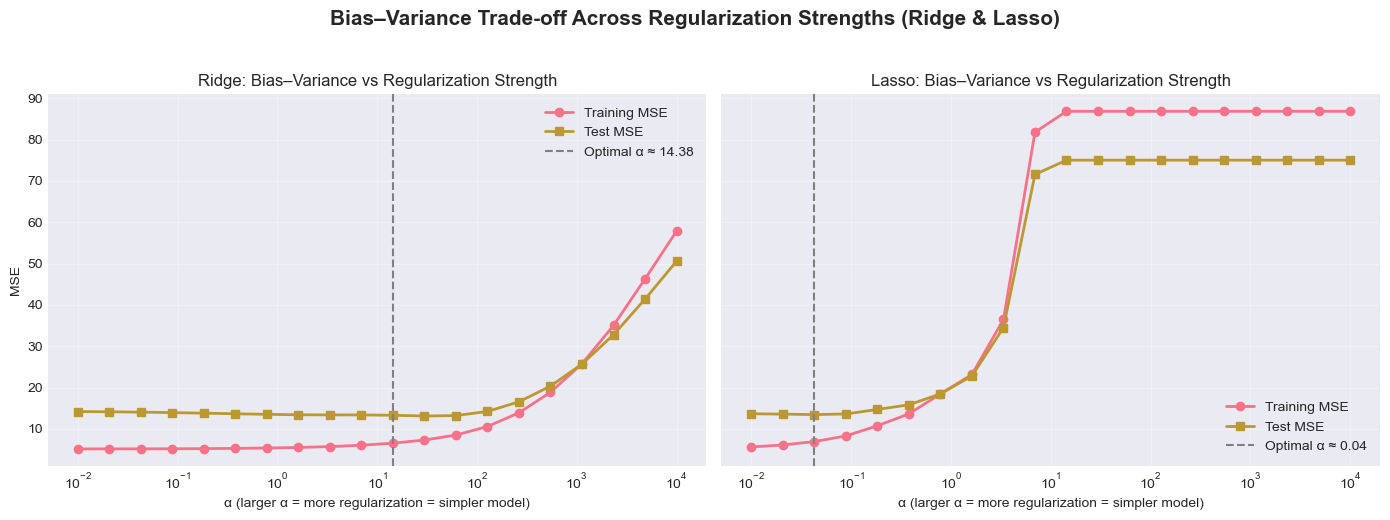

In [ ]:

#Lasso: Bias–Variance vs Alpha (Error Curves)
lasso_train_mse_path = []
lasso_test_mse_path = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_poly, y_train)

    y_train_pred = lasso.predict(X_train_poly)
    y_test_pred = lasso.predict(X_test_poly)

    lasso_train_mse_path.append(mean_squared_error(y_train, y_train_pred))
    lasso_test_mse_path.append(mean_squared_error(y_test, y_test_pred))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Ridge ---
ax1.semilogx(alphas, ridge_train_mse_path, 'o-', label='Training MSE', linewidth=2)
ax1.semilogx(alphas, ridge_test_mse_path,  's-', label='Test MSE', linewidth=2)
ax1.axvline(ridge_alpha_opt, color='gray', linestyle='--',
            label=f'Optimal α ≈ {ridge_alpha_opt:.2f}')
ax1.set_xlabel('α (larger α = more regularization = simpler model)')
ax1.set_ylabel('MSE')
ax1.set_title('Ridge: Bias–Variance vs Regularization Strength')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Lasso ---
ax2.semilogx(alphas, lasso_train_mse_path, 'o-', label='Training MSE', linewidth=2)
ax2.semilogx(alphas, lasso_test_mse_path,  's-', label='Test MSE', linewidth=2)
ax2.axvline(lasso_alpha_opt, color='gray', linestyle='--',
            label=f'Optimal α ≈ {lasso_alpha_opt:.2f}')
ax2.set_xlabel('α (larger α = more regularization = simpler model)')
ax2.set_title('Lasso: Bias–Variance vs Regularization Strength')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('Bias–Variance Trade-off Across Regularization Strengths (Ridge & Lasso)',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('ridge_lasso_bias_variance_alpha.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ridge_lasso_bias_variance_alpha.png")


## Ridge & Lasso Coefficient Paths (vs α)

In this section, we visualize how the **regression coefficients** of Ridge and Lasso models evolve as the **regularization strength (α)** increases.  
These plots, known as **regularization paths**, provide valuable insight into how each method handles **model complexity** and **feature shrinkage**.



 Regularization Paths: Ridge & Lasso
----------------------------------------
✓ Saved: regularization_paths.png


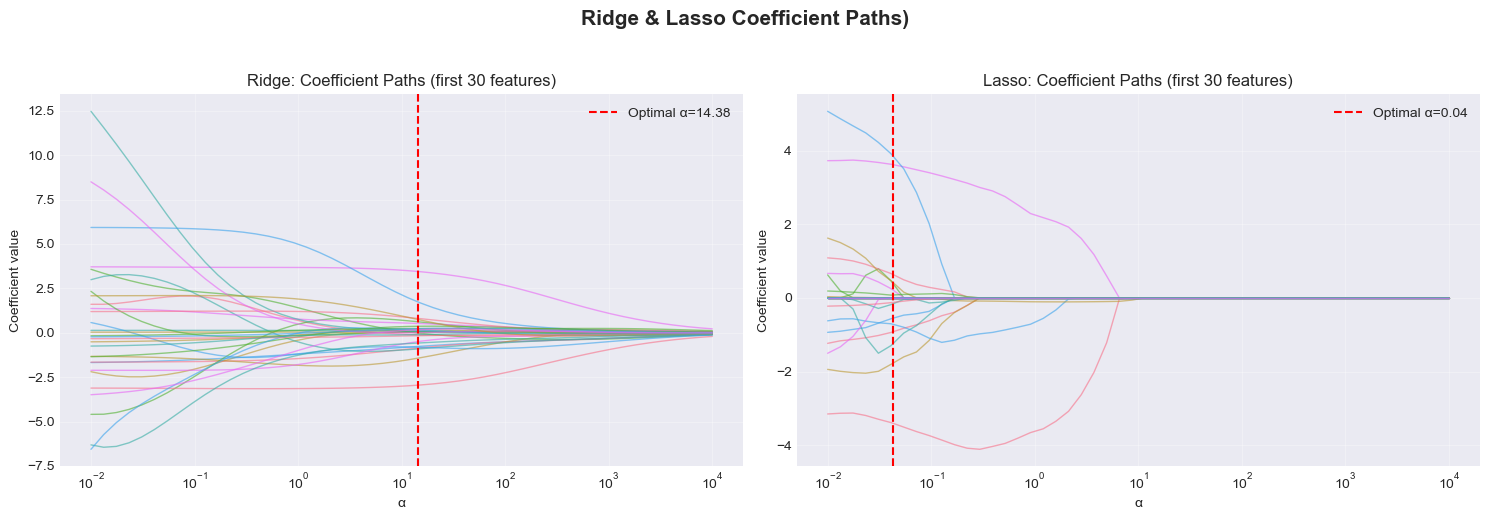

In [ ]:

# RIDGE & LASSO COEFFICIENT PATHS (vs α)
print("\n Regularization Paths: Ridge & Lasso")
print("-" * 40)

alphas_path = np.logspace(-2, 4, 50)

ridge_coefs = []
lasso_coefs = []

for a in alphas_path:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_poly, y_train)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_poly, y_train)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

n_show = min(30, ridge_coefs.shape[1])

for i in range(n_show):
    ax1.semilogx(alphas_path, ridge_coefs[:, i], linewidth=1, alpha=0.6)
ax1.set_xlabel('α')
ax1.set_ylabel('Coefficient value')
ax1.set_title('Ridge: Coefficient Paths (first 30 features)')
ax1.axvline(ridge_alpha_opt, color='red', linestyle='--',
            label=f'Optimal α={ridge_alpha_opt:.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

for i in range(n_show):
    ax2.semilogx(alphas_path, lasso_coefs[:, i], linewidth=1, alpha=0.6)
ax2.set_xlabel('α')
ax2.set_ylabel('Coefficient value')
ax2.set_title('Lasso: Coefficient Paths (first 30 features)')
ax2.axvline(lasso_alpha_opt, color='red', linestyle='--',
            label=f'Optimal α={lasso_alpha_opt:.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('Ridge & Lasso Coefficient Paths)',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('regularization_paths.png', dpi=300, bbox_inches='tight')
print("✓ Saved: regularization_paths.png")



In [ ]:

print("\n Training vs Test Error Comparison")
print("-" * 40)

methods = ['Linear (Polynomial)', 'Ridge', 'Lasso']
train_mses = [results[m]['train_mse'] for m in methods]
test_mses = [results[m]['test_mse'] for m in methods]
train_r2s = [results[m]['train_r2'] for m in methods]
test_r2s = [results[m]['test_r2'] for m in methods]

comparison_df = pd.DataFrame({
    'Method': methods,
    'Features': [results[m]['features'] for m in methods],
    'Train_MSE': train_mses,
    'Test_MSE': test_mses,
    'Gap': [test_mses[i] - train_mses[i] for i in range(len(methods))],
    'Train_R2': train_r2s,
    'Test_R2': test_r2s
}).round(4)

print(comparison_df.to_string(index=False))



 Training vs Test Error Comparison
----------------------------------------
             Method  Features  Train_MSE  Test_MSE    Gap  Train_R2  Test_R2
Linear (Polynomial)       104     5.1403   14.2897 9.1495    0.9408   0.8051
              Ridge       104     6.5334   13.2830 6.7496    0.9248   0.8189
              Lasso       104     6.9150   13.4471 6.5321    0.9204   0.8166


### Reflection Questions

1. **Model Comparison:**  
   How do the **Ridge** and **Lasso** models perform compared to the **unregularized polynomial regression** model?  
   - Discuss differences in Test MSE, R², and generalization ability.  
   - What effect does regularization have on overfitting?

2. **Graph Interpretation:**  
   Examine the **Bias–Variance vs α** and **Coefficient Path** plots.  
   - What trends do you observe as α increases?  
   - How does Ridge’s coefficient shrinkage differ from Lasso’s feature selection behavior?  
   - What do these visual patterns tell you about the trade-off between model complexity and stability?

1) The unregularized polynomial regression model achieves a very low training MSE of 5.14 and a high R² of 0.9408, indicating it fits the training data extremely well. However, its test MSE is much higher at 14.29 and the test R² drops to 0.8051, resulting in a large train-test gap of 9.15. This indicates that the model is overfitting, capturing noise in the training data that does not generalize to new data. In contrast, the regularized models, Ridge and Lasso, show slightly higher training errors (6.53 and 6.92, respectively) and slightly lower training R² values (0.9248 and 0.9204), but their test performance improves. Ridge achieves a test MSE of 13.28 and test R² of 0.8189, while Lasso achieves a test MSE of 13.45 and test R² of 0.8166. The smaller gap between training and test errors in both regularized models indicates better generalization. 
- Overall, regularization reduces overfitting by penalizing large coefficients, trading a small amount of training accuracy for improved predictive performance on unseen data. Ridge performs slightly better than Lasso in this case, although Lasso has the added benefit of potentially performing feature selection by shrinking some coefficients to zero.

2. Graph Interpretation

- when α is very small, the models have low bias and high variance which can lead to overfitting. As α grows, training error rises because the model becomes less flexible, while test error initially remains constant. However, beyond the optimal α, test error also increases sharply, indicating underfitting caused by excessive bias. Ridge reaches its optimal point at a much higher α of 14.38 as compared to Lasso around 0.04, showing that Lasso is more sensitive to regularization.

- Ridge regression applies L2 regularization which shrinks coefficients gradually toward zero but never eliminates them completely. This means Ridge retains all features, though with smaller weights, making it useful when all predictors contribute some information. on the other hand, Lasso uses L1 regularization, which forces many coefficients to become exactly zero as α increases. This behavior enables Lasso to perform automatic feature selection, creating a sparse model that is easier to interpret and often more efficient when many predictors are irrelevant.

- Increasing α reduces variance and improves stability by preventing large swings in coefficients, but it also increases bias, reducing the model’s ability to capture complex relationships.